In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import lightgbm as lgb

from sklearn.metrics import mean_squared_error, mean_absolute_error, f1_score, make_scorer
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold

# from sklearn.feature_selection import SelectKBest, f_regression

In [2]:
np.random.seed(7)

# metrics

In [3]:
def mae(y_true, y_pred) :
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    
    y_true = y_true.reshape(1, -1)[0]
    y_pred = y_pred.reshape(1, -1)[0]
    over_threshold = y_true >= 0.1
    
    return np.mean(np.abs(y_true[over_threshold] - y_pred[over_threshold]))

def fscore(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    
    y_true = y_true.reshape(1, -1)[0]
    y_pred = y_pred.reshape(1, -1)[0]
    remove_NAs = y_true >= 0
    
    y_true = np.where(y_true[remove_NAs] >= 0.1, 1, 0)
    y_pred = np.where(y_pred[remove_NAs] >= 0.1, 1, 0)
    
    return (f1_score(y_true, y_pred))

def maeOverFscore(y_true, y_pred):
    return mae(y_true, y_pred) / (fscore(y_true, y_pred) + 1e-07)

def score(y_val, pred):
    f_value =  fscore(y_val, pred)
    mae_value = maeOverFscore(y_val, pred)
    print(f"fscore        : {f_value}")
    print(f"maeOverFscore : {mae_value}")
    
    return (f_value, mae_value)




fscore_sklearn = make_scorer(fscore)
maeOverFscore_sklearn = make_scorer(maeOverFscore)

# data load

In [4]:
base = os.getcwd()
data_path = os.path.join(base, 'data')
submit_path = os.path.join(base, 'submit')
model_path = os.path.join(base, 'model')

def load_data(name):
    return np.load(os.path.join(data_path, f"{name}.npy"))

def reshape(data):
    return data.reshape(data.shape[0] * 40 * 40, data.shape[-1])

In [5]:
data = reshape(load_data('dl_train'))

# Feature Selection

## select K
![img](feacture_selection.PNG)

### selectK 7
- [False, False,  True,  True,  True,  True,  True,  True, False, False, False, False, False, True]

### selectK 8
- [False, False,  True,  True,  True,  True,  True,  True, False, False, False, True, False, True]

In [6]:
selectK_7 = [2, 3, 4, 5, 6, 7, 13]
selectK_8 = [2, 3, 4, 5, 6, 7, 11, 13]

# seperate dataset

In [7]:
X = data[:, :-1]
Y = data[:,  -1].reshape(data.shape[0], 1)
data = range(data.shape[0])
print(X.shape, Y.shape)

(121561600, 14) (121561600, 1)


# Kfold

In [8]:
kfold = KFold(n_splits=4, random_state=7, shuffle=False)
scores = list()
Best_iterations = list()

for i, (train_idx, val_idx) in enumerate(kfold.split(data)):
    clf = lgb.LGBMRegressor(boosting_type='gbdt', num_leaves=31, max_depth=- 1, learning_rate=0.01, \
                            n_estimators=10000, subsample_for_bin=200000, objective=None, class_weight=None, \
                            min_split_gain=0.0, min_child_weight=0.001, min_child_samples=20, subsample=1.0, \
                            subsample_freq=0, colsample_bytree=1.0, reg_alpha=0.0, reg_lambda=0.0, \
                            random_state=7, n_jobs=- 1, silent=True, importance_type='split')
    

    clf.fit(X[train_idx, :], Y[train_idx, 0], eval_set=[(X[val_idx, :], Y[val_idx, 0])], \
            early_stopping_rounds=50, \
            
            verbose=True)
    
#     clf.booster_.save_model('clf.txt')
    
    scores.append(score(clf.predict(X[val_idx, :]), Y[val_idx, :]))
    Best_iterations.append()

/home/ubuntu/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


[1]	valid_0's l2: 3.62025
Training until validation scores don't improve for 100 rounds
[2]	valid_0's l2: 3.60018
[3]	valid_0's l2: 3.58048
[4]	valid_0's l2: 3.5612
[5]	valid_0's l2: 3.54225
[6]	valid_0's l2: 3.52371
[7]	valid_0's l2: 3.5055
[8]	valid_0's l2: 3.48772
[9]	valid_0's l2: 3.47018
[10]	valid_0's l2: 3.45305
[11]	valid_0's l2: 3.43636
[12]	valid_0's l2: 3.41983
[13]	valid_0's l2: 3.40359
[14]	valid_0's l2: 3.38775
[15]	valid_0's l2: 3.37216
[16]	valid_0's l2: 3.35696
[17]	valid_0's l2: 3.34204
[18]	valid_0's l2: 3.32738
[19]	valid_0's l2: 3.31303
[20]	valid_0's l2: 3.29897
[21]	valid_0's l2: 3.28513
[22]	valid_0's l2: 3.27155
[23]	valid_0's l2: 3.25835
[24]	valid_0's l2: 3.24527
[25]	valid_0's l2: 3.23255
[26]	valid_0's l2: 3.21996
[27]	valid_0's l2: 3.20769
[28]	valid_0's l2: 3.19563
[29]	valid_0's l2: 3.18377
[30]	valid_0's l2: 3.1722
[31]	valid_0's l2: 3.1609
[32]	valid_0's l2: 3.14975
[33]	valid_0's l2: 3.13876
[34]	valid_0's l2: 3.12799
[35]	valid_0's l2: 3.11752
[36]	v

[297]	valid_0's l2: 2.48478
[298]	valid_0's l2: 2.48469
[299]	valid_0's l2: 2.48426
[300]	valid_0's l2: 2.48422
[301]	valid_0's l2: 2.48381
[302]	valid_0's l2: 2.48342
[303]	valid_0's l2: 2.48333
[304]	valid_0's l2: 2.48294
[305]	valid_0's l2: 2.48258
[306]	valid_0's l2: 2.4825
[307]	valid_0's l2: 2.48203
[308]	valid_0's l2: 2.48176
[309]	valid_0's l2: 2.48139
[310]	valid_0's l2: 2.48101
[311]	valid_0's l2: 2.48095
[312]	valid_0's l2: 2.48051
[313]	valid_0's l2: 2.48014
[314]	valid_0's l2: 2.48011
[315]	valid_0's l2: 2.47976
[316]	valid_0's l2: 2.4794
[317]	valid_0's l2: 2.47911
[318]	valid_0's l2: 2.47877
[319]	valid_0's l2: 2.47839
[320]	valid_0's l2: 2.47831
[321]	valid_0's l2: 2.47797
[322]	valid_0's l2: 2.47788
[323]	valid_0's l2: 2.47747
[324]	valid_0's l2: 2.47741
[325]	valid_0's l2: 2.47709
[326]	valid_0's l2: 2.47676
[327]	valid_0's l2: 2.47648
[328]	valid_0's l2: 2.47621
[329]	valid_0's l2: 2.47593
[330]	valid_0's l2: 2.47561
[331]	valid_0's l2: 2.47531
[332]	valid_0's l2: 2.

[591]	valid_0's l2: 2.44021
[592]	valid_0's l2: 2.44015
[593]	valid_0's l2: 2.44007
[594]	valid_0's l2: 2.44
[595]	valid_0's l2: 2.43989
[596]	valid_0's l2: 2.4398
[597]	valid_0's l2: 2.43976
[598]	valid_0's l2: 2.4397
[599]	valid_0's l2: 2.43962
[600]	valid_0's l2: 2.43948
[601]	valid_0's l2: 2.43942
[602]	valid_0's l2: 2.4393
[603]	valid_0's l2: 2.43923
[604]	valid_0's l2: 2.43914
[605]	valid_0's l2: 2.43909
[606]	valid_0's l2: 2.43901
[607]	valid_0's l2: 2.43895
[608]	valid_0's l2: 2.43887
[609]	valid_0's l2: 2.43881
[610]	valid_0's l2: 2.43869
[611]	valid_0's l2: 2.43864
[612]	valid_0's l2: 2.43854
[613]	valid_0's l2: 2.43849
[614]	valid_0's l2: 2.43835
[615]	valid_0's l2: 2.4383
[616]	valid_0's l2: 2.43816
[617]	valid_0's l2: 2.43812
[618]	valid_0's l2: 2.43806
[619]	valid_0's l2: 2.43802
[620]	valid_0's l2: 2.43795
[621]	valid_0's l2: 2.43786
[622]	valid_0's l2: 2.43779
[623]	valid_0's l2: 2.43775
[624]	valid_0's l2: 2.4377
[625]	valid_0's l2: 2.43757
[626]	valid_0's l2: 2.43752


[886]	valid_0's l2: 2.42309
[887]	valid_0's l2: 2.42307
[888]	valid_0's l2: 2.423
[889]	valid_0's l2: 2.42298
[890]	valid_0's l2: 2.42293
[891]	valid_0's l2: 2.42288
[892]	valid_0's l2: 2.42282
[893]	valid_0's l2: 2.42277
[894]	valid_0's l2: 2.42274
[895]	valid_0's l2: 2.42269
[896]	valid_0's l2: 2.42266
[897]	valid_0's l2: 2.42262
[898]	valid_0's l2: 2.42259
[899]	valid_0's l2: 2.42251
[900]	valid_0's l2: 2.4225
[901]	valid_0's l2: 2.42247
[902]	valid_0's l2: 2.42246
[903]	valid_0's l2: 2.42243
[904]	valid_0's l2: 2.42235
[905]	valid_0's l2: 2.42234
[906]	valid_0's l2: 2.4223
[907]	valid_0's l2: 2.42228
[908]	valid_0's l2: 2.42219
[909]	valid_0's l2: 2.42216
[910]	valid_0's l2: 2.42213
[911]	valid_0's l2: 2.42209
[912]	valid_0's l2: 2.42206
[913]	valid_0's l2: 2.42197
[914]	valid_0's l2: 2.4219
[915]	valid_0's l2: 2.42184
[916]	valid_0's l2: 2.42181
[917]	valid_0's l2: 2.42178
[918]	valid_0's l2: 2.42176
[919]	valid_0's l2: 2.42174
[920]	valid_0's l2: 2.42173
[921]	valid_0's l2: 2.421

[1174]	valid_0's l2: 2.41339
[1175]	valid_0's l2: 2.41337
[1176]	valid_0's l2: 2.41336
[1177]	valid_0's l2: 2.41333
[1178]	valid_0's l2: 2.41333
[1179]	valid_0's l2: 2.41333
[1180]	valid_0's l2: 2.41329
[1181]	valid_0's l2: 2.41324
[1182]	valid_0's l2: 2.41323
[1183]	valid_0's l2: 2.4132
[1184]	valid_0's l2: 2.41318
[1185]	valid_0's l2: 2.41317
[1186]	valid_0's l2: 2.41315
[1187]	valid_0's l2: 2.4131
[1188]	valid_0's l2: 2.4131
[1189]	valid_0's l2: 2.41307
[1190]	valid_0's l2: 2.41304
[1191]	valid_0's l2: 2.41301
[1192]	valid_0's l2: 2.41298
[1193]	valid_0's l2: 2.41296
[1194]	valid_0's l2: 2.41296
[1195]	valid_0's l2: 2.41294
[1196]	valid_0's l2: 2.4129
[1197]	valid_0's l2: 2.41287
[1198]	valid_0's l2: 2.41285
[1199]	valid_0's l2: 2.41279
[1200]	valid_0's l2: 2.41277
[1201]	valid_0's l2: 2.41276
[1202]	valid_0's l2: 2.41275
[1203]	valid_0's l2: 2.41273
[1204]	valid_0's l2: 2.41268
[1205]	valid_0's l2: 2.41267
[1206]	valid_0's l2: 2.41263
[1207]	valid_0's l2: 2.41262
[1208]	valid_0's l

[1459]	valid_0's l2: 2.40688
[1460]	valid_0's l2: 2.40686
[1461]	valid_0's l2: 2.40683
[1462]	valid_0's l2: 2.40681
[1463]	valid_0's l2: 2.40679
[1464]	valid_0's l2: 2.40678
[1465]	valid_0's l2: 2.40675
[1466]	valid_0's l2: 2.40674
[1467]	valid_0's l2: 2.40672
[1468]	valid_0's l2: 2.40669
[1469]	valid_0's l2: 2.40669
[1470]	valid_0's l2: 2.40666
[1471]	valid_0's l2: 2.40665
[1472]	valid_0's l2: 2.40664
[1473]	valid_0's l2: 2.40661
[1474]	valid_0's l2: 2.40661
[1475]	valid_0's l2: 2.40658
[1476]	valid_0's l2: 2.40657
[1477]	valid_0's l2: 2.40655
[1478]	valid_0's l2: 2.40654
[1479]	valid_0's l2: 2.40654
[1480]	valid_0's l2: 2.40652
[1481]	valid_0's l2: 2.40651
[1482]	valid_0's l2: 2.4065
[1483]	valid_0's l2: 2.40647
[1484]	valid_0's l2: 2.40647
[1485]	valid_0's l2: 2.40644
[1486]	valid_0's l2: 2.40643
[1487]	valid_0's l2: 2.40642
[1488]	valid_0's l2: 2.40639
[1489]	valid_0's l2: 2.40633
[1490]	valid_0's l2: 2.40628
[1491]	valid_0's l2: 2.40626
[1492]	valid_0's l2: 2.40625
[1493]	valid_0'

[1743]	valid_0's l2: 2.40189
[1744]	valid_0's l2: 2.40187
[1745]	valid_0's l2: 2.40183
[1746]	valid_0's l2: 2.40181
[1747]	valid_0's l2: 2.4018
[1748]	valid_0's l2: 2.40177
[1749]	valid_0's l2: 2.40176
[1750]	valid_0's l2: 2.40175
[1751]	valid_0's l2: 2.40175
[1752]	valid_0's l2: 2.40174
[1753]	valid_0's l2: 2.40173
[1754]	valid_0's l2: 2.40167
[1755]	valid_0's l2: 2.40164
[1756]	valid_0's l2: 2.40162
[1757]	valid_0's l2: 2.4016
[1758]	valid_0's l2: 2.40158
[1759]	valid_0's l2: 2.40157
[1760]	valid_0's l2: 2.40156
[1761]	valid_0's l2: 2.40156
[1762]	valid_0's l2: 2.40155
[1763]	valid_0's l2: 2.40154
[1764]	valid_0's l2: 2.40152
[1765]	valid_0's l2: 2.4015
[1766]	valid_0's l2: 2.40148
[1767]	valid_0's l2: 2.40147
[1768]	valid_0's l2: 2.40143
[1769]	valid_0's l2: 2.40142
[1770]	valid_0's l2: 2.40141
[1771]	valid_0's l2: 2.40138
[1772]	valid_0's l2: 2.40135
[1773]	valid_0's l2: 2.40134
[1774]	valid_0's l2: 2.40132
[1775]	valid_0's l2: 2.40131
[1776]	valid_0's l2: 2.4013
[1777]	valid_0's l

KeyboardInterrupt: 

In [24]:
for f_value, mae_value in scores:
    print(f"fscore : {f_value} \t maeOverFscore : {mae_value}")

fscore : 0.6335426349159089 	 maeOverFscore : 1.6396066001397651


# 시각화

NotFittedError: No booster found. Need to call fit beforehand.

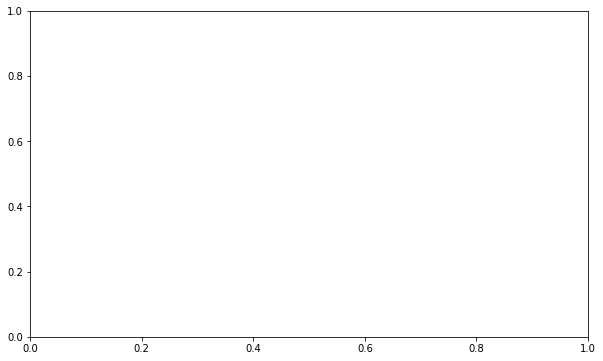

In [25]:
fig, ax = plt.subplots(figsize=(10,6))
lgb.plot_importance(clf, ax)

# 제출

In [27]:
def submit(clf, name, preprocess=None):
    x_test = reshape(load_data('test'))
    
    pred = clf.predict(x_test)

    submission = pd.read_csv(os.path.join(data_path, 'sample_submission.csv'))
    submission.iloc[:, 1:] = pred.reshape(-1, 1600)

    submission.to_csv(os.path.join(submit_path, f'{name}.csv'), index=False)

In [28]:
submit(clf, 'lightbgm_nfold_4_28_2000')

NotFittedError: No booster found. Need to call fit beforehand.

In [23]:
line = 112000000
print(f"train : {line} , val : {Y.shape[0] - line}")

x_train = X[:line, :]
y_train = Y[:line, 0]

x_val = X[line:, :]
y_val = Y[line:, 0]

In [24]:
x_val.shape, y_val.shape

((9561600, 14), (9561600,))

In [32]:
clf = lgb.LGBMRegressor(boosting_type='gbdt', num_leaves=31, max_depth=- 1, learning_rate=0.01, \
                         n_estimators=400, subsample_for_bin=200000, objective=None, class_weight=None, \
                         min_split_gain=0.0, min_child_weight=0.001, min_child_samples=20, subsample=1.0, \
                         subsample_freq=0, colsample_bytree=1.0, reg_alpha=0.0, reg_lambda=0.0, random_state=None, \
                         n_jobs=- 1, silent=True, importance_type='split')

clf.fit(x_train, y_train, eval_set=[(x_val, y_val)], \
        early_stopping_rounds=100, \
        verbose=True)

score(clf.predict(X[val_idx, :]), Y[val_idx, :])

/home/ubuntu/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:253: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  warnings.warn("Usage of np.ndarray subset (sliced data) is not recommended "


[1]	valid_0's l2: 2.62434
Training until validation scores don't improve for 100 rounds
[2]	valid_0's l2: 2.60849
[3]	valid_0's l2: 2.59315
[4]	valid_0's l2: 2.57792
[5]	valid_0's l2: 2.56319
[6]	valid_0's l2: 2.54859
[7]	valid_0's l2: 2.53441
[8]	valid_0's l2: 2.52025
[9]	valid_0's l2: 2.50663
[10]	valid_0's l2: 2.49304
[11]	valid_0's l2: 2.4799
[12]	valid_0's l2: 2.46702
[13]	valid_0's l2: 2.45418
[14]	valid_0's l2: 2.44171
[15]	valid_0's l2: 2.4295
[16]	valid_0's l2: 2.41738
[17]	valid_0's l2: 2.40559
[18]	valid_0's l2: 2.39396
[19]	valid_0's l2: 2.38272
[20]	valid_0's l2: 2.37164
[21]	valid_0's l2: 2.36083
[22]	valid_0's l2: 2.34997
[23]	valid_0's l2: 2.33943
[24]	valid_0's l2: 2.32906
[25]	valid_0's l2: 2.31878
[26]	valid_0's l2: 2.30871
[27]	valid_0's l2: 2.29897
[28]	valid_0's l2: 2.28927
[29]	valid_0's l2: 2.27988
[30]	valid_0's l2: 2.27071
[31]	valid_0's l2: 2.26151
[32]	valid_0's l2: 2.25257
[33]	valid_0's l2: 2.2438
[34]	valid_0's l2: 2.23518
[35]	valid_0's l2: 2.22678
[36]	

[297]	valid_0's l2: 1.73858
[298]	valid_0's l2: 1.73845
[299]	valid_0's l2: 1.73806
[300]	valid_0's l2: 1.73795
[301]	valid_0's l2: 1.73781
[302]	valid_0's l2: 1.73758
[303]	valid_0's l2: 1.73745
[304]	valid_0's l2: 1.73721
[305]	valid_0's l2: 1.73698
[306]	valid_0's l2: 1.73688
[307]	valid_0's l2: 1.73677
[308]	valid_0's l2: 1.73668
[309]	valid_0's l2: 1.73644
[310]	valid_0's l2: 1.73633
[311]	valid_0's l2: 1.73599
[312]	valid_0's l2: 1.73588
[313]	valid_0's l2: 1.73577
[314]	valid_0's l2: 1.73555
[315]	valid_0's l2: 1.73543
[316]	valid_0's l2: 1.73518
[317]	valid_0's l2: 1.73483
[318]	valid_0's l2: 1.73474
[319]	valid_0's l2: 1.73465
[320]	valid_0's l2: 1.73444
[321]	valid_0's l2: 1.73435
[322]	valid_0's l2: 1.73424
[323]	valid_0's l2: 1.73385
[324]	valid_0's l2: 1.73357
[325]	valid_0's l2: 1.73347
[326]	valid_0's l2: 1.73308
[327]	valid_0's l2: 1.73296
[328]	valid_0's l2: 1.73275
[329]	valid_0's l2: 1.73265
[330]	valid_0's l2: 1.73255
[331]	valid_0's l2: 1.73218
[332]	valid_0's l2: 

(0.6392624073411757, 1.7811428259684727)

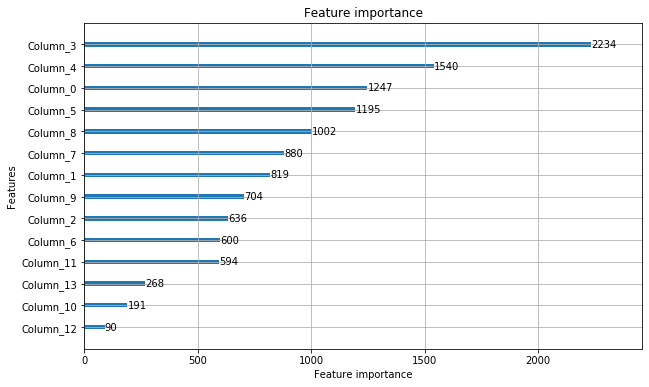

In [33]:
fig, ax = plt.subplots(figsize=(10,6))
lgb.plot_importance(clf, ax)

In [34]:
submit(clf, 'lightbgm_all_features_all_data_2')

# Lightbgm

# Lightbgm train

In [ ]:
params = {'learning_rate': 0.01, 'max_depth': -1, 'boosting': 'gbdt', 
          'objective': 'regression', 'metric': 'mae', 'is_training_metric': True, 
          'num_leaves': 1024, 'feature_fraction': 0.9, 'bagging_fraction': 0.7, 
          'bagging_freq': 5, 'seed':7}

model = lgb.train(params, train, 1000, val, verbose_eval=10, \
                  early_stopping_rounds=100)

In [ ]:
pred = model.predict(x_val)

score(y_val, pred)

# Feature Selection

# 시각화

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))
lgb.plot_importance(model, ax)

In [ ]:
# lgb_param = {
#     'objective': 'regression',
#     'metrics': maeOverFscore_sklearn,
#     'learning_rate' : 0.01,
#     'eval_metric': maeOverFscore_sklearn,
#     'early_stopping_rounds' : 100,
#     'eval_set': val_data,
#     'verbose': True,
#     'stratified':False,
#     'verbose_eval': 10,
#     'nfold': 5,
#     'num_boost_round': 99999,
# }

# cv_result = lgb.cv(
#     lgb_param,
#     train_data
# )

# lgb_model = lgb.train(
#   lgb_param,
#   train_data,
#   num_boost_round=len(cv_result['l1-mean'])
# )

# Submit

In [ ]:
def submit(clf, name, preprocess=None):
    x_test = reshape(load_data('test'))
    
    if preprocess is not None:
        x_test = preprocess.transform(x_test)
        print("transform")
    
    pred = clf.predict(x_test)

    submission = pd.read_csv(os.path.join(data_path, 'sample_submission.csv'))
    submission.iloc[:, 1:] = pred.reshape(-1, 1600)

    submission.to_csv(os.path.join(submit_path, f'{name}.csv'), index = False)

In [ ]:
submit(lgb_model, 'lightbgm_selectK')

- https://dacon.io/competitions/official/235591/mysubmission/
- D:\인공지능_공모전\github\submit